In [19]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Convolutional Neural networks 101

Convolution neural networks are one of the most succesfull types of neural networks for image recognition and an integral part of reigniting the interest in neural networks. 

In this lab we'll experiment with inserting 2D-convolution layers in the fully connected neural networks introduced in LAB1. We'll furhter experiment with stacking of convolution layers, max pooling and strided convolutions which are all important techniques in current convolution neural network architectures. Lastly we'll try to visualize the learned convolution filters and try to understand what kind of features they learn to recognize.


If you are unfamilar with the the convolution operation  https://github.com/vdumoulin/conv_arithmetic have a nice visualization of different convolution variants. For a more indept tutorial please see http://cs231n.github.io/convolutional-networks/ or http://neuralnetworksanddeeplearning.com/chap6.html. Lastly if you are ambitious and want implement a convolution neural network from scratch please see an exercise for our Deep Learning summer school last year https://github.com/DTU-deeplearning/day2-Conv

In [20]:
#LOAD the mnist data. To speed up training we'll only work on a subset of the data.
#Note that we reshape the data from (nsamples, num_features)= (nsamples, nchannels*rows*cols)  -> (nsamples, nchannels, rows, cols)
# in order to retain the spatial arrangements of the pixels
data = np.load('mnist.npz')
num_classes = 10
nchannels,rows,cols = 1,28,28
x_train = data['X_train'][:1000].astype('float32')
x_train = x_train.reshape((-1,nchannels,rows,cols))
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
x_valid = x_valid.reshape((-1,nchannels,rows,cols))
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
x_test = x_test.reshape((-1,nchannels,rows,cols))
targets_test = data['y_test'][:500].astype('int32')

print "Information on dataset"
print "x_train", x_train.shape
print "targets_train", targets_train.shape
print "x_valid", x_valid.shape
print "targets_valid", targets_valid.shape
print "x_test", x_test.shape
print "targets_test", targets_test.shape

Information on dataset
x_train (1000, 1, 28, 28)
targets_train (1000,)
x_valid (500, 1, 28, 28)
targets_valid (500,)
x_test (500, 1, 28, 28)
targets_test (500,)


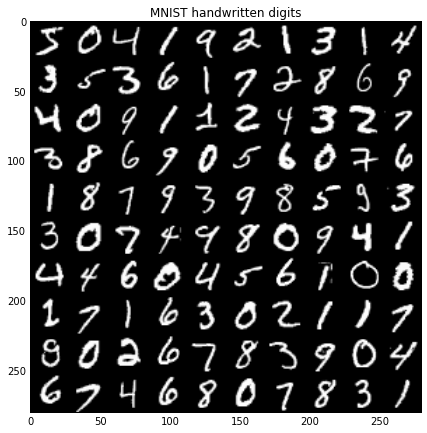

In [21]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

### Documentation on contrib layers
Check out the [github page](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/layers/python/layers/layers.py) for information on contrib layers (not well documented in their api).

In [22]:
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax

In [23]:
# define a simple feed forward neural network

# hyperameters of the model
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]
num_filters_conv1 = 16
kernel_size_conv1 = [5, 5] # [height, width]
stride_conv1 = [1, 1] # [stride_height, stride_width]
num_l1 = 100
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, channels, height, width])
l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW
#is_training = tf.placeholder(tf.bool)#used for dropout

# Building the layers of the neural network
# we define the variable scope, so we more easily can recognise our variables later
#l_conv1 = convolution2d(l_reshape, num_filters_conv1, kernel_size_conv1, stride_conv1, scope="l_conv1")
l_flatten = flatten(l_reshape, scope="flatten") # use l_conv1 instead of l_reshape
l1 = fully_connected(l_flatten, num_l1, activation_fn=relu, scope="l1")
#l1 = dropout(l1, is_training=is_training, scope="dropout")
y = fully_connected(l1, num_classes, activation_fn=softmax, scope="y")

In [24]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_classes])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y+1e-8), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)

In [25]:
#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[y], feed_dict={x_pl: x})
#res = sess.run(fetches=[y], feed_dict={x_pl: x, is_training: False}) # for when using dropout
print "y", res[0].shape

y (45, 10)


Epoch 1 : Train Loss 2.003186e-01 , Train acc 0.684000,  Valid acc 0.620000 
Epoch 2 : Train Loss 1.276601e-01 , Train acc 0.787000,  Valid acc 0.718000 
Epoch 3 : Train Loss 8.495402e-02 , Train acc 0.841000,  Valid acc 0.768000 
Epoch 4 : Train Loss 6.161602e-02 , Train acc 0.876000,  Valid acc 0.788000 
Epoch 5 : Train Loss 4.877902e-02 , Train acc 0.900000,  Valid acc 0.812000 
Epoch 6 : Train Loss 4.052538e-02 , Train acc 0.916000,  Valid acc 0.828000 
Epoch 7 : Train Loss 3.486546e-02 , Train acc 0.928000,  Valid acc 0.834000 
Epoch 8 : Train Loss 3.057365e-02 , Train acc 0.942000,  Valid acc 0.838000 
Epoch 9 : Train Loss 2.715341e-02 , Train acc 0.950000,  Valid acc 0.842000 
Epoch 10 : Train Loss 2.434796e-02 , Train acc 0.956000,  Valid acc 0.846000 

Test set Acc:  0.864000


(<matplotlib.text.Text at 0x7f19b2e38310>,
 (0.75, 1.03))

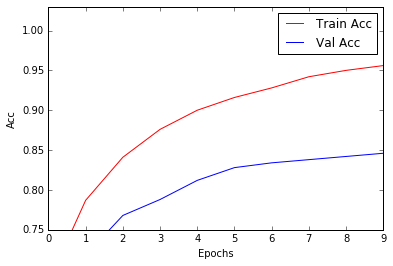

In [26]:
#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]
            feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes)}
            #feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes), is_training: True}
            fetches_train = [train_op, cross_entropy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
            batch_loss = res[1] #this will do the complete backprob pass
            cur_loss += batch_loss
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            # what to feed our accuracy op
            feed_dict_eval_train = {x_pl: x_batch}
            #feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0] 
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            # what to feed our accuracy op
            feed_dict_eval_train = {x_pl: x_batch}
            #feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0]
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
# what to feed our accuracy op
feed_dict_eval_train = {x_pl: x_test}
#feed_dict_eval_train = {x_pl: x_test, is_training: False}
# deciding which parts to fetch
fetches_eval_train = [y]
# running the validation
res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
# collecting and storing predictions
net_out = res[0] 
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments 1

 1) Note the performance of the standard feedforward neural network. Add a 2D convolution layer before the dense hidden layer and confirm that it increases the generalization performance of the network (try num_filters=16 and filter_size=5 as a starting point). 
 
 2) Can the performance be increases even further by stacking more convolution layers ?
 
 3) Maxpooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. Try to either: 
 
     a) add a maxpool layer(add arguement pool_size=2)  after the convolution layer or
     b) set add stride=2 to the arguments of the convolution layer. 
  Verify that this decreases spatial dimension of the image. (print l_conv.output_shape or print   l_maxpool.output_shape). Does this increase the performance of the network (you may need to stack multiple layers or increase the number of filters to increase performance) ?
  


In [27]:
# define a simple feed forward neural network

# hyperameters of the model
num_classes = 10
channels = x_train.shape[1]
height = x_train.shape[2]
width = x_train.shape[3]
num_filters_conv1 = 16
kernel_size_conv1 = [5, 5] # [height, width]
stride_conv1 = [1, 1] # [stride_height, stride_width]
num_l1 = 100
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, channels, height, width])
l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW
is_training = tf.placeholder(tf.bool)#used for dropout

# Building the layers of the neural network
# we define the variable scope, so we more easily can recognise our variables later
l_conv1 = convolution2d(l_reshape, num_filters_conv1, kernel_size_conv1, stride_conv1, scope="l_conv1")
l_conv1 = max_pool2d(l_conv1, [2, 2], scope="l_conv1")
l_flatten = flatten(l_conv1, scope="flatten") # use l_conv1 instead of l_reshape
l1 = fully_connected(l_flatten, num_l1, activation_fn=relu, scope="l1")
l1 = dropout(l1, is_training=is_training, scope="dropout")
y = fully_connected(l1, num_classes, activation_fn=softmax, scope="y")


# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_classes])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y+1e-8), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)

#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
#res = sess.run(fetches=[y], feed_dict={x_pl: x})
res = sess.run(fetches=[y], feed_dict={x_pl: x, is_training: False}) # for when using dropout
print "y", res[0].shape

y (45, 10)


Epoch 1 : Train Loss 1.982472e-01 , Train acc 0.755000,  Valid acc 0.674000 
Epoch 2 : Train Loss 1.204577e-01 , Train acc 0.831000,  Valid acc 0.752000 
Epoch 3 : Train Loss 7.877838e-02 , Train acc 0.876000,  Valid acc 0.794000 
Epoch 4 : Train Loss 6.075049e-02 , Train acc 0.903000,  Valid acc 0.836000 
Epoch 5 : Train Loss 4.870755e-02 , Train acc 0.910000,  Valid acc 0.862000 
Epoch 6 : Train Loss 4.047068e-02 , Train acc 0.929000,  Valid acc 0.866000 
Epoch 7 : Train Loss 3.456064e-02 , Train acc 0.939000,  Valid acc 0.874000 
Epoch 8 : Train Loss 3.400279e-02 , Train acc 0.947000,  Valid acc 0.876000 
Epoch 9 : Train Loss 2.941096e-02 , Train acc 0.954000,  Valid acc 0.884000 
Epoch 10 : Train Loss 2.910259e-02 , Train acc 0.959000,  Valid acc 0.898000 

Test set Acc:  0.908000


(<matplotlib.text.Text at 0x7f19aafd9710>,
 (0.75, 1.03))

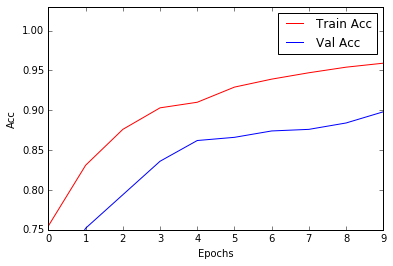

In [28]:
#Training Loop
from confusionmatrix import ConfusionMatrix
batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
try:
    for epoch in range(num_epochs):
        #Forward->Backprob->Update params
        cur_loss = 0
        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            target_batch = targets_train[idx]
            #feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes)}
            feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes), is_training: True}
            fetches_train = [train_op, cross_entropy]
            res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
            batch_loss = res[1] #this will do the complete backprob pass
            cur_loss += batch_loss
        loss += [cur_loss/batch_size]

        confusion_valid = ConfusionMatrix(num_classes)
        confusion_train = ConfusionMatrix(num_classes)

        for i in range(num_batches_train):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_train[idx]
            targets_batch = targets_train[idx]
            # what to feed our accuracy op
            #feed_dict_eval_train = {x_pl: x_batch}
            feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0] 
            preds = np.argmax(net_out, axis=-1) 
            confusion_train.batch_add(targets_batch, preds)

        confusion_valid = ConfusionMatrix(num_classes)
        for i in range(num_batches_valid):
            idx = range(i*batch_size, (i+1)*batch_size)
            x_batch = x_valid[idx]
            targets_batch = targets_valid[idx]
            # what to feed our accuracy op
            #feed_dict_eval_train = {x_pl: x_batch}
            feed_dict_eval_train = {x_pl: x_batch, is_training: False}
            # deciding which parts to fetch
            fetches_eval_train = [y]
            # running the validation
            res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
            # collecting and storing predictions
            net_out = res[0]
            preds = np.argmax(net_out, axis=-1) 

            confusion_valid.batch_add(targets_batch, preds)

        train_acc_cur = confusion_train.accuracy()
        valid_acc_cur = confusion_valid.accuracy()

        train_acc += [train_acc_cur]
        valid_acc += [valid_acc_cur]
        print "Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
        % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur)
except KeyboardInterrupt:
    pass
    

#get test set score
confusion_test = ConfusionMatrix(num_classes)
# what to feed our accuracy op
#feed_dict_eval_train = {x_pl: x_test}
feed_dict_eval_train = {x_pl: x_test, is_training: False}
# deciding which parts to fetch
fetches_eval_train = [y]
# running the validation
res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
# collecting and storing predictions
net_out = res[0] 
preds = np.argmax(net_out, axis=-1) 
confusion_test.batch_add(targets_test, preds)
print "\nTest set Acc:  %f" %(confusion_test.accuracy())


epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Visualization of filters
Convolution filters can be interpreted as spatial feature detectors picking up different image features such as edges, corners etc. Below we provide code for visualization of the filters. The best results are obtained with fairly large filters of size 9 and either 16 or 36 filters. 

In [29]:
# to start with we print the names of the weights in our graph
# to see what operations we are allowed to perform on the variables in our graph, try:
print(dir(tf.all_variables()[0]))
# you will notice it has "name" and "value", which we will build a dictionary from
names_and_vars = {var.name: sess.run(var.value()) for var in tf.all_variables()}
print(names_and_vars.keys())
# getting the name was easy, just use .name on the variable object
# getting the value in a numpy array format is slightly more tricky
# we need to first get a variable object, then turn it into a tensor with .value()
# and the evaluate the tensor with sess.run(...)

['SaveSliceInfo', '_AsTensor', '_OverloadAllOperators', '_OverloadOperator', '_TensorConversionFunction', '__abs__', '__add__', '__and__', '__array_priority__', '__class__', '__delattr__', '__dict__', '__div__', '__doc__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__invert__', '__iter__', '__le__', '__lt__', '__mod__', '__module__', '__mul__', '__neg__', '__new__', '__or__', '__pow__', '__radd__', '__rand__', '__rdiv__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rmod__', '__rmul__', '__ror__', '__rpow__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '__xor__', '_as_graph_element', '_caching_device', '_init_from_args', '_init_from_proto', '_initial_value', '_initializer_op', '_save_slice_info', '_set_save_slice_info', '_snapshot', '_variable', 'assign', 'assign_add', 'assign_sub', 'count_up_to', 'device',

(5, 5, 1, 16) i.e. the shape is filter_size, filter_size, num_channels, num_filters
learned filter values


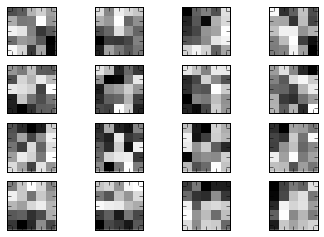

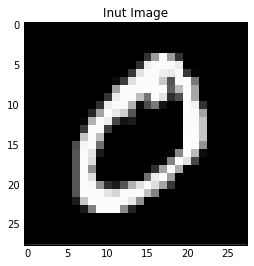

Response from input image convolved with the filters
y (45, 10)


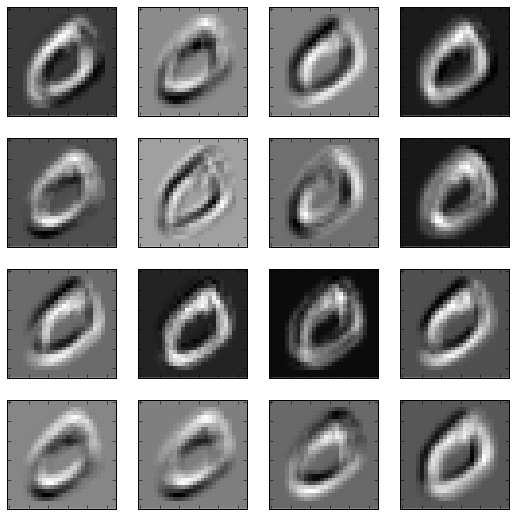

In [30]:
### ERROR - If you get a key error, then you need to define l_conv1 in your model!
if not u'l_conv1/weights:0' in names_and_vars:
    print "You need to go back and define a convolutional layer in the network."
else:
    np_W = names_and_vars[u'l_conv1/weights:0'] # get the filter values from the first conv layer
    print np_W.shape, "i.e. the shape is filter_size, filter_size, num_channels, num_filters"
    filter_size, _, num_channels, num_filters = np_W.shape
    n = int(num_filters**0.5)

    # reshaping the last dimension to be n by n
    np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
    fig, ax = plt.subplots(n,n)
    print "learned filter values"
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(np_W_res[:,:,0,i,j], cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())


    idx = 1
    plt.figure()
    plt.imshow(x_train[idx,0],cmap='gray',interpolation='none')
    plt.title('Inut Image')
    plt.show()

    #visalize the filters convolved with an input image
    from scipy.signal import convolve2d
    np_W_res = np_W.reshape(filter_size, filter_size, num_channels, n, n)
    fig, ax = plt.subplots(n,n,figsize=(9,9))
    print "Response from input image convolved with the filters"
    for i in range(n):
        for j in range(n):
            ax[i,j].imshow(convolve2d(x_train[1,0],np_W_res[:,:,0,i,j],mode='same'),
                           cmap='gray',interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())
            
            
#Test the forward pass
x = np.random.normal(0,1, (45, 1,28,28)).astype('float32') #dummy data

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
#res = sess.run(fetches=[y], feed_dict={x_pl: x})
res = sess.run(fetches=[y], feed_dict={x_pl: x, is_training: False}) # for when using dropout
print "y", res[0].shape

# Assignment 2

The visualized filters will likely look most like noise due to the small amount of training data.

 1) Try to use 10000 traning examples instead and visualise the filters again
 
 2) Dropout is a very usefull technique for preventing overfitting. Try to add a DropoutLayer after the convolution layer and hidden layer. This should increase both performance and the "visual appeal" of the filters
 
 3) Batch normalization is a recent innovation for improving generalization performance. Try to insert batch normalization layers into the network to improve performance. 
 
 


# More Fun with convolutional networks
### Get the data

In [31]:
!wget -N https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz

--2016-10-19 22:26:31--  https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.98.163
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.98.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43046126 (41M) [application/octet-stream]
Saving to: 'mnist_cluttered_60x60_6distortions.npz'

100%[======================================>] 43,046,126   598KB/s   in 1m 43s 

2016-10-19 22:28:17 (410 KB/s) - 'mnist_cluttered_60x60_6distortions.npz' saved [43046126/43046126]



In the data the each mnist digit (20x20 pixels) has been placed randomly in a 60x60 canvas. To make the task harder each canvas has then been cluttered with small pieces of digits. In this task it is helpfull for a network if it can focus only on the digit and ignore the rest.

The ``TransformerLayer`` lets us do this. The transformer layer learns an affine transformation which lets the network zoom, rotate and skew. If you are interested you should read the paper, but the main idea is that you can let a small convolutional network determine the parameters of the affine transformation. You then apply the affine transformation to the input data. Usually this also involves downsampling which forces the model to zoom in on the relevant parts of the data. After the affine transformation we can use a larger conv net to do the classification. 
This is possible because you can backprop through an affine transformation if you use bilinear interpolation.

In [32]:
import os
import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d
pool = max_pool2d
conv = convolution2d
dense = fully_connected
from tensorflow.python.ops.nn import relu, softmax
from tensorflow.python.framework.ops import reset_default_graph

from spatial_transformer import transformer

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 60
NUM_CLASSES = 10
mnist_cluttered = "mnist_cluttered_60x60_6distortions.npz"

Train samples: (50000, 1, 60, 60)
Validation samples: (10000, 1, 60, 60)
Test samples: (10000, 1, 60, 60)


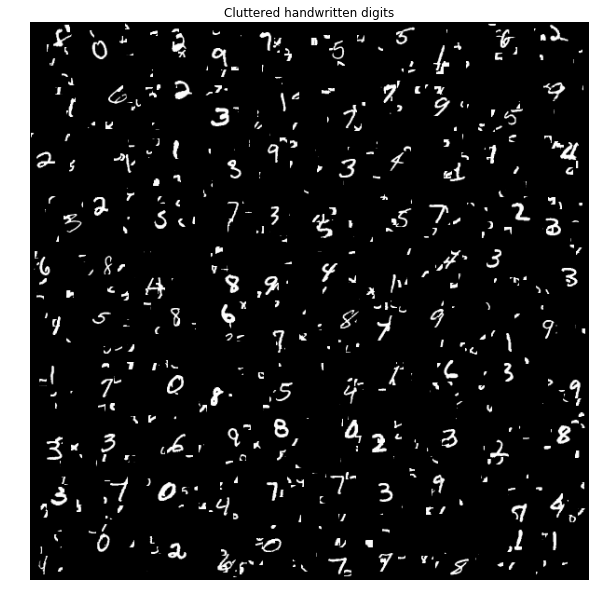

In [33]:
def load_data():
    data = np.load(mnist_cluttered)
    X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
    X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
    X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)

    # reshape for convolutions
    X_train = X_train.reshape((X_train.shape[0], 1, DIM, DIM))
    X_valid = X_valid.reshape((X_valid.shape[0], 1, DIM, DIM))
    X_test = X_test.reshape((X_test.shape[0], 1, DIM, DIM))
    
    print "Train samples:", X_train.shape
    print "Validation samples:", X_valid.shape
    print "Test samples:", X_test.shape

    return dict(
        X_train=np.asarray(X_train, dtype='float32'),
        y_train=y_train.astype('int32'),
        X_valid=np.asarray(X_valid, dtype='float32'),
        y_valid=y_valid.astype('int32'),
        X_test=np.asarray(X_test, dtype='float32'),
        y_test=y_test.astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
data = load_data()

idx = 0
canvas = np.zeros((DIM*10, 10*DIM))
for i in range(10):
    for j in range(10):
        canvas[i*DIM:(i+1)*DIM, j*DIM:(j+1)*DIM] = data['X_train'][idx].reshape((DIM, DIM))
        idx += 1
plt.figure(figsize=(10, 10))
plt.imshow(canvas, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')

plt.show()

## Building the model

We use a model where the localization network is a two layer convolution network which operates directly on the image input. The output from the localization network is a 6 dimensional vector specifying the parameters in the affine transformation.

We set up the transformer layer to initially do the identity transform, similarly to [1]. If the output from the localization networks is [t1, t2, t3, t4, t5, t6] then t1 and t5 determines zoom, t2 and t4 determines skewness, and t3 and t6 move the center position. By setting the initial values of the bias vector to 

```
|1, 0, 0|
|0, 1, 0|
```
and the final W of the localization network to all zeros we ensure that in the beginning of training the network works as a pooling layer. 

The output of the localization layer feeds into the transformer layer which applies the transformation to the image input. In our setup the transformer layer downsamples the input by a factor 3.

Finally a 2 layer convolution layer and 2 fully connected layers calculates the output probabilities.


### The model
```
Input -> localization_network -> TransformerLayer -> output_network -> predictions
   |                                |
   >--------------------------------^
```




In [34]:
reset_default_graph()
def build_model(x_pl, input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    # Setting up placeholder, this is where your data enters the graph!
    l_reshape = tf.transpose(x_pl, [0, 2, 3, 1]) # TensorFlow uses NHWC instead of NCHW

    # make distributed representation of input image for localization network
    loc_l1 = pool(l_reshape, kernel_size=[2, 2], scope="loc_l1")
    loc_l2 = conv(loc_l1, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="loc_l2")
    loc_l3 = pool(loc_l2, kernel_size=[2, 2], scope="loc_l3")
    loc_l4 = conv(loc_l3, num_outputs=8, kernel_size=[5, 5], stride=[1, 1], padding="SAME", scope="loc_l4")
    loc_l4_flatten = flatten(loc_l4, scope="loc_l4_flatten")
    loc_l5 = dense(loc_l4_flatten, num_outputs=50, activation_fn=relu, scope="loc_l5")
    # set up weights for transformation (notice we always need 6 output neurons)
    W_loc_out = tf.get_variable("W_loc_out", [50, 6], initializer=tf.constant_initializer(0.0))
    initial = np.array([[1, 0, 0], [0, 1, 0]])
    initial = initial.astype('float32')
    initial = initial.flatten()
    b_loc_out = tf.Variable(initial_value=initial, name='b_loc_out')
    loc_out = tf.matmul(loc_l5, W_loc_out) + b_loc_out

    # spatial transformer
    l_trans1 = transformer(l_reshape, loc_out, out_size=(DIM//3, DIM//3))
    l_trans1.set_shape([None, DIM//3, DIM//3, 1])
    l_trans1_valid = tf.transpose(l_trans1, [0, 2, 3, 1]) # Back into NCHW for validation

    print "Transformer network output shape: ", l_trans1.get_shape()

    # classification network
    class_l1 = conv(l_trans1, num_outputs=16, kernel_size=[3, 3], scope="class_l1")
    class_l2 = pool(class_l1, kernel_size=[2, 2], scope="class_l2")
    class_l3 = conv(class_l2, num_outputs=16, kernel_size=[3, 3], scope="class_l3")
    class_l4 = pool(class_l3, kernel_size=[2, 2], scope="class_l4")
    class_l4_flatten = flatten(class_l4, scope="class_l4_flatten")
    class_l5 = dense(class_l4_flatten, num_outputs=256, activation_fn=relu, scope="class_l5")
    l_out = dense(class_l5, num_outputs=output_dim, activation_fn=softmax, scope="l_out")

    return l_out, l_trans1_valid

x_pl = tf.placeholder(tf.float32, [None, 1, DIM, DIM])
model, l_transform = build_model(x_pl, DIM, DIM, NUM_CLASSES)
#model_params = lasagne.layers.get_all_params(model, trainable=True)

Transformer network output shape:  (?, 20, 20, 1)


In [40]:
# y_ is a placeholder variable taking on the value of the target batch.
y_pl = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])
lr_pl = tf.placeholder(tf.float32, shape=[])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_pl * tf.log(model+1e-8), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# defining our optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr_pl)

# applying the gradients
train_op = optimizer.minimize(cross_entropy)

In [41]:
# test the forward pass
x = np.random.normal(0,1, (45, 1,60,60)).astype('float32') #dummy data
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[model], feed_dict={x_pl: x})
print "y", res[0].shape

y (45, 10)


### Training the model
Unfortunately NVIDIA has yet to squeeze a TitanX into a labtop and training convnets on CPU is painfully slow. After 10 epochs you should see that model starts to zoom in on the digits. 

In [42]:
def train_epoch(X, y, learning_rate):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_tr = X[idx]
        y_batch_tr = y[idx]
        fetches_tr = [train_op, cross_entropy, model]
        feed_dict_tr = {x_pl: X_batch_tr, y_pl: onehot(y_batch_tr, NUM_CLASSES), lr_pl: learning_rate}
        res = sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr)
        cost_batch, output_train = tuple(res[1:3])
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch_tr == preds)
    print ""
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    pred_list = []
    transform_list = []
    for i in range(num_batches):
        if i % 10 == 0:
            print i,
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch_val = X[idx]
        fetches_val = [model, l_transform]
        feed_dict_val = {x_pl: X_batch_val}
        res = sess.run(fetches=fetches_val, feed_dict=feed_dict_val)
        output_eval, transform_eval = tuple(res)
        pred_list.append(output_eval)
        transform_list.append(transform_eval)
    transform_eval = np.concatenate(transform_list, axis=0)
    preds = np.concatenate(pred_list, axis=0)
    preds = np.argmax(preds, axis=-1)
    acc = np.mean(preds == y)
    print ""
    return acc, transform_eval

In [ ]:
valid_accs, train_accs, test_accs = [], [], []
learning_rate=0.0001
try:
    for n in range(NUM_EPOCHS):
        print "Epoch %d:" % n
        print 'train ',
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'], learning_rate)
        print 'valid ',
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        print 'test ',
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        # learning rate annealing
        if (n+1) % 20 == 0:
            learning_rate = learning_rate * 0.7
            print "New LR:", learning_rate

        print "train cost {0:.2}, train acc {1:.2}, val acc {2:.2}, test acc {3:.2}".format(
                train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

Epoch 0:
train  0

### Plot errors and zoom

In [ ]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

In [ ]:
plt.figure(figsize=(7,14))
for i in range(3):
    plt.subplot(321+i*2)
    plt.imshow(data['X_test'][i].reshape(DIM, DIM), cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Original 60x60', fontsize=20)
    plt.axis('off')
    plt.subplot(322+i*2)
    plt.imshow(test_transform[i].reshape(DIM//3, DIM//3).T, cmap='gray', interpolation='none')
    if i == 0:
        plt.title('Transformed 20x20', fontsize=20)
    plt.axis('off')
    
    
plt.tight_layout()
plt.show()

# A few pointers for image classification
If you want do image classification using a pretrained model is often a good choice, especially if you have limited amounts of labeled data.

An often used pretrained network is the Google Inception model. TensorFlow has a guide for using their current state-of-the-art pretrained model in their [model repository](https://github.com/tensorflow/models/tree/master/inception). Torch7 and Theano have similar pretrained models that you can find with google. 

Currently the best performing image network is the [ResNet](https://arxiv.org/pdf/1512.03385v1.pdf) model. Torch7 has an interesting blog post about residual nets. http://torch.ch/blog/2016/02/04/resnets.html